In [44]:
import pandas as pd

data=pd.read_csv("C:\\Users\\gunja\\OneDrive\\Desktop\\merc_bench\\train.csv\\train.csv")

In [45]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [46]:
##Lets focus on the object dtype columns
data.loc[:,data.dtypes==object]

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n
...,...,...,...,...,...,...,...,...
4204,ak,s,as,c,d,aa,d,q
4205,j,o,t,d,d,aa,h,h
4206,ak,v,r,a,d,aa,g,e
4207,al,r,e,f,d,aa,l,u


In [47]:
##There are 8 categorical variables.
#We need to covert these to numerical columns using label encoder followed by one hot encoder.We will use 
#label encoding for any categorical variables with only 2 categories and one hot encoding for categorical variables have more 
#than 2 categories.The biggest downside of one hot encoding is that it inflates the number of variables where the caterories are 
#numerous.In this dataset we already have 378 columns.Lets see at how many columns we end after one hot encoding the categorical variables


from sklearn.preprocessing import LabelEncoder

le=LabelEncoder()
le_count=0

#Iterate through the columns
for col in data:
    if data[col].dtype=='object':
        if len(list(data[col].unique()))<=2:
            le.fit_transform(data[col])
            le_count+=1


In [48]:
print('%d columns were label encoded.'%le_count )

0 columns were label encoded.


In [49]:
#one-hot encoding for categorical variables
data=pd.get_dummies(data)

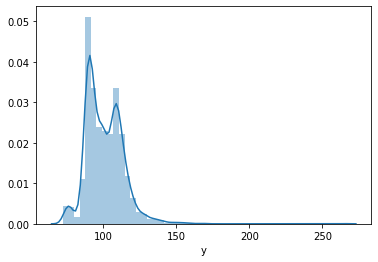

In [50]:
#Lets see the distribution of our target variable
import seaborn as sns
import matplotlib.pyplot as plt

sns.distplot(data['y'])

plt.show()

In [51]:
#This variable is heavily right tailed.If we get rid of the outliers I think we can make its distribution pretty 
#close to normal.

data['y'].describe()

#75% of the data is less than 109.From the distribution I think we can stop at 150.Lets see the number of obs greater than 150

len(data['y'].loc[data['y']>150])

15

In [52]:
###So we would lose just 15 obs out of 4209.Lets get rid of these rows

data=data.loc[data['y']<=150]



In [53]:
##Lets separate the predictor and the target variables

X=data.drop(['y'],axis=1)
y=data['y']

In [54]:
y

0       130.81
1        88.53
2        76.26
3        80.62
4        78.02
         ...  
4204    107.39
4205    108.77
4206    109.22
4207     87.48
4208    110.85
Name: y, Length: 4194, dtype: float64

In [55]:
#Lets divide the data into train and test, also predictor variables and label

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=1)


In [56]:
###There were 378 columns.Now there are 564.It is difficult to work with so many predictor variables.These are all 
# binary categorical variables.Lets run this through random forest regressor because it has an inbuilt mechanism for feature
# selection


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

rf=RandomForestRegressor(n_estimators=100,criterion='mse',max_depth=6,min_samples_split=2,min_samples_leaf=1,oob_score=True)

rf.fit(X_train,y_train)



RandomForestRegressor(max_depth=6, oob_score=True)

In [57]:
rf.oob_score_

0.6119744286250484

In [91]:
##Random Forest has an inbuilt mechanism to calculate feature importances.Lets see the important features here
FI=pd.DataFrame([feature_name,score] for feature_name,score in zip(X.columns,rf.feature_importances_))
FI.columns=('name','score')
FI=FI.sort_values(by='score',ascending=False)
FI=FI.loc[FI['score']>=0.01]
FI=FI.sort_values(by='score')
FI



,name,score
19,X29,0.010205
217,X232,0.011878
0,ID,0.014744
124,X136,0.027790
248,X263,0.029749
107,X118,0.037568
108,X119,0.041585
299,X315,0.134063
298,X314,0.583191


Text(0, 0.5, 'Features')

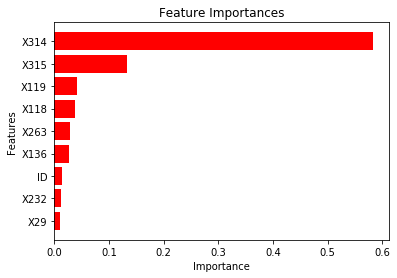

In [93]:
###Lets plot the features which are at least 1% important

plt.figure()
plt.title('Feature Importances')
plt.barh(FI['name'],FI['score'],color='r')
plt.xlabel('Importance')
plt.ylabel('Features')

In [15]:
##Not a very good accuracy.Lets try XGboost before we optimise the random forest  hyperparameters

import xgboost as xgb

In [16]:
##We need to transform our data into a format that xgboost can handle.This format is called DMatrix
D_train=xgb.DMatrix(X_train,label=y_train)
D_test=xgb.DMatrix(X_test,label=y_test)

C:\Users\gunja\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [136]:
#Our data is set so I will define some important parameters of our gradient boosting ensemble.The default objective is 'reg:squaredloss'
#but I am still defining it

param={'eta': 0.3,'max_depth': 6,'gamma':0.05,'objective':'reg:squarederror','subsample':0.6,'colsample_bytree':0.6}

num_round=20

model=xgb.train(param,D_train,num_round)


In [137]:
##Prediction

pred=model.predict(D_test)

In [138]:
import numpy as np
y_test=np.array(y_test)

In [139]:
import  pandas as pd

df=pd.DataFrame(y_test,pred)

from sklearn.metrics import mean_squared_error

print('Root mean squared error is',np.sqrt(mean_squared_error(y_test,pred)))

Root mean squared error is 7.576359992236254


In [140]:
from sklearn.metrics import r2_score

r2=r2_score(y_test,pred)



In [29]:
r2

0.6199866579361615